# Step 5

In [28]:
import pydot
import matplotlib.pyplot as plt
import time
import math
import random
import numpy as np
from scipy.special import comb

## Uploading the functions from other files

In [44]:
%run '/Users/tomascarrilho/Desktop/Faculdade/Data Visualization/Project/Data_Visualization/Step4.ipynb'

## Getting the data

In [30]:
def get_data_subgraph(file):
    with open(file, 'r') as dot_file:
        dot_data = dot_file.read()
    graph = pydot.graph_from_dot_data(dot_data)[0]

    nodes_dict = {str(subgraph.get_name().strip('"').split(' ')[0]+subgraph.get_name().strip('"').split(' ')[-1]):[node.get_name() for node in subgraph.get_nodes()] for subgraph in graph.get_subgraphs()}
    edges_list = [(edge.get_source(),edge.get_destination()) for edge in graph.get_edges()]

    return nodes_dict, edges_list

#nodes_dict, edges_list = get_data_subgraph("Datasets/argnet.dot")
#nodes_dict, edges_list = get_data_subgraph("Datasets/polblogs.dot")
#print(nodes_dict)
#print(edges_list)

def get_subgraphs(file):
    with open(file, 'r') as dot_file:
        dot_data = dot_file.read()
    graph = pydot.graph_from_dot_data(dot_data)[0]

    #for node in graph.get_nodes():
    #    print(node.get_attributes()['value'])
    nodes_dict = {'left': [node.get_name() for node in graph.get_nodes() if int(node.get_attributes()['value']) == 0], 'right': [node.get_name() for node in graph.get_nodes() if int(node.get_attributes()['value']) == 1] }
    return nodes_dict

#pol = get_subgraphs("Datasets/polblogs.dot") #left = 758, right = 732, total = 1490

In [31]:
def intra_subgraphs_edges(file,sg=True):
    if sg == True:
        nodes_dict, edges_list = get_data_subgraph(file)
    else:
        nodes_dict = get_subgraphs(file)
        x, edges_list = get_data_subgraph(file)
    #intra_edges = {str(first_graph.split(' ')[0]+first_graph.split(' ')[-1]) : [edge for edge in edges_list if edge[0] in nodes_dict[first_graph] and edge[1] in nodes_dict[first_graph]] for first_graph in nodes_dict.keys() }#{'Gap_Youngest
    intra_edges = {first_graph: [edge for edge in edges_list if edge[0] in nodes_dict[first_graph] and edge[1] in nodes_dict[first_graph]] for first_graph in nodes_dict.keys() }#{'Gap_Youngest
    return intra_edges

#print(intra_subgraphs_edges("Datasets/argnet.dot"))
#intra = intra_subgraphs_edges("Datasets/polblogs.dot",sg=False))

def inter_subgraphs_edges(file,sg=True):
    #nodes_dict, edges_list = get_data_subgraph(file)
    if sg == True:
        nodes_dict, edges_list = get_data_subgraph(file)
    else:
        nodes_dict = get_subgraphs(file)
        x, edges_list = get_data_subgraph(file)
    #inter_edges = {str(first_graph.split(' ')[0]+sec_graph.split(' ')[0]) : [] for first_graph in nodes_dict.keys() for sec_graph in [key for key in nodes_dict.keys() if key != first_graph] }#{'Gap_Youngest}
    #inter_edges = {str(first_graph.split(' ')[0]+first_graph.split(' ')[-1]+'_'+sec_graph.split(' ')[0]+sec_graph.split(' ')[-1]): [edge for edge in edges_list if edge[0] in nodes_dict[first_graph] and edge[1] in nodes_dict[sec_graph]] for first_graph in nodes_dict.keys() for sec_graph in [key for key in nodes_dict.keys() if key != first_graph] }#{'Gap_Youngest}
    inter_edges = {str(first_graph+'_'+sec_graph): [edge for edge in edges_list if edge[0] in nodes_dict[first_graph] and edge[1] in nodes_dict[sec_graph]] for first_graph in nodes_dict.keys() for sec_graph in [key for key in nodes_dict.keys() if key != first_graph] }#{'Gap_Youngest}

    return inter_edges

#inter_subgraphs_edges("Datasets/argnet.dot")
#inter = inter_subgraphs_edges("Datasets/polblogs.dot",sg=False)

In [32]:
# intra = intra_subgraphs_edges("Datasets/polblogs.dot",sg=False)
# print(list(intra.keys()))
# print(len(list(intra.keys())))
# print(len(intra['left'])+len(intra['right']))

In [33]:
# inter = inter_subgraphs_edges("Datasets/polblogs.dot",sg=False)
# print(list(inter.keys()))
# print(len(list(inter.keys())))
# print(len(inter['left_right'])+len(inter['right_left']))

In [34]:
# print(len(inter['left_right'])+len(inter['right_left'])+len(intra['left'])+len(intra['right']))

## Force Directed Layout

### Compatibility

In [35]:
def distance(X,Y):
    return math.sqrt((X[0] - Y[0]) ** 2 + (X[1] - Y[1]) ** 2)

def vector(node_positions,P = 0):
    if P != 0:
        return (node_positions[P[1]][0] - node_positions[P[0]][0],  node_positions[P[1]][1] - node_positions[P[0]][1])
    else:
        #[(0,0),(1,1)]
        return (node_positions[1][0] - node_positions[0][0],  node_positions[1][1] - node_positions[0][1])

def lenght(vector):
    return math.sqrt(vector[0] ** 2 + vector[1] ** 2)

def dot_prod(u,v):
    return u[0] * v[0] + u[1] * v[1]

def sum_vectors(u,v):
    return (u[0] +v[0] , u[1] + v[1])

def alpha_vector(alpha,u):
    return (u[0]*alpha,u[1]*alpha)

def mid_point(node_positions,P=0):
    '''P is an edge like ('A','B'), and node_positions a dic {'A':(x,y),...}
    '''
    if P != 0:
        return ((node_positions[P[0]][0] + node_positions[P[1]][0]) / 2, (node_positions[P[0]][1] + node_positions[P[1]][1]) / 2)
    else:
         return ((node_positions[0][0] + node_positions[1][0]) / 2, (node_positions[0][1] + node_positions[1][1]) / 2)


def unit_vector(vector):
    return (vector[0]/lenght(vector),vector[1]/lenght(vector))

def angle_compatibility(P, Q, node_positions):
    return abs(dot_prod(vector(node_positions,P), vector(node_positions,Q)) / (lenght( vector(node_positions,P)) * lenght( vector(node_positions,Q))))

def scale_compatibility(P, Q, node_positions):
    avg_length = (lenght( vector(node_positions,P)) + lenght( vector(node_positions,Q))) / 2
    return 2 / (avg_length / min(lenght(vector(node_positions,P)), lenght( vector(node_positions,Q))) + max(lenght(vector(node_positions,P)), lenght( vector(node_positions,Q))) / avg_length)

def distance_compatibility(P, Q, node_positions):
    avg_length = (lenght( vector(node_positions,P)) + lenght( vector(node_positions,Q))) / 2
    return avg_length / (avg_length + distance( mid_point(node_positions,P),mid_point(node_positions,Q)))

def visibility_compatibility(P, Q, node_positions):
    if unit_vector(vector(node_positions,P)) == unit_vector(vector(node_positions,Q)): # parallel
        def vis(P,Q,node_positions):
            distance_pm_im = distance(mid_point(node_positions,P),(mid_point(node_positions,Q)[0], node_positions[P[1]][1]))#i_m = (q_midpoint[0], node_positions[P[1]][1]),  q_midpoint = mid_point(Q,node_positions)
            distance_i0_i1 = distance((node_positions[Q[0]][0],node_positions[P[1]][1]),(node_positions[Q[1]][0],node_positions[P[1]][1]))#i0 = (node_positions[Q[0]][0],node_positions[P[1]][1]),#i1 = (node_positions[Q[1]][0],node_positions[P[1]][1]) 
            return max(1 - 2 * distance_pm_im/  distance_i0_i1, 0)
        return min(vis(P,Q,node_positions),vis(Q,P,node_positions))
    return 1

def combined_compatibility(P, Q, node_positions):
    angle_compat = angle_compatibility(P, Q, node_positions)
    scale_compat = scale_compatibility(P, Q, node_positions)
    position_compat = distance_compatibility(P, Q, node_positions)
    visibility_compat = visibility_compatibility(P, Q, node_positions)
    return angle_compat * scale_compat * position_compat * visibility_compat


#print(vector([(1,1),(4, 2)]))
P=('A','B')
Q=('C','D')
# #node_positions = {'A':(0,0),'B':(1,0),'C':(0.3,1),'D':(1.3,1)}
# #node_positions = {'A':(0,0),'B':(1,0),'C':(0,1),'D':(1,1)}
# node_positions = {'A':(0.5,0),'B':(0.5,1),'C':(0,0.5),'D':(1,0.5)}

# Example node positions
#nodes_positions = {'A': (0, 0), 'B': (1, 1), 'C': (2, 0), 'D': (3, 2)}
nodes_positions = {'A': (1, 1), 'B': (3, 1), 'C': (1, 2), 'D': (4, 1),'E':(3,2)}
E = [('A', 'B'),('A','E'),('C', 'D')]

#print(mid_point(E[1],nodes_positions))

#print(angle_compatibility(P, Q, nodes_positions))
#print(scale_compatibility(P, Q, nodes_positions))
#print(distance_compatibility(P, Q, nodes_positions))
#print("Visibility compatibility:", visibility_compatibility(P, Q, nodes_positions))
#print("Combined compatibility:", combined_compatibility(E[1], E[2], nodes_positions))

### Edge Bundling

In [36]:
def edge_bundling(E, nodes_positions, C, I, s, K):
    c = 0  # Cycle counter
    t = 1  # Iteration counter
    B = {}
    while c < C:
        
        #print(c,'ite')
        if c == 0 and t == 1:
            #print('inital')
            for edge in E:#edge -> ('A','B')
                start_node, end_node = edge
                B[edge] = [nodes_positions[start_node],mid_point(nodes_positions,edge),nodes_positions[end_node]]

            #print('first B',B)
        #c+=1
        elif c!=0 and t== 1: #while c<=2:
            #print('else',c,B)

            for edge,path in B.items():#edge->('A','B')
                for i in range(1,len(path)+2**c,2):#path-> [(0, 0), (0.5, 0.5), (1, 1)]
                    B[edge].insert(i,mid_point((path[i-1],path[i])))
            #print(c,'-th',B)
        #c+=1
            

        #apply the forces
        FPi = {edge:[(0,0) for _ in range(len(path))] for edge,path in B.items()}
        #print(FPi)
        for edge,path in B.items():
            for i in range(1,len(path)-1):
                #print('##############################')
                #print('edge',edge,'mid point',path[i])
                #print('i-1',path[i-1])
                #print('i',path[i])
                #print('i+1',path[i+1])
                kP = K*(len(path)-2)/distance(path[0],path[-1])
                #print(kP)

                #print([path[i],path[i-i]])
                #print([path[i],path[i+i]])
                spring = sum_vectors(alpha_vector(kP,vector([path[i],path[i-1]])), alpha_vector(kP,vector([path[i],path[i+1]])))
                force = spring
                #rint('spring force',spring)
                for other_edge,other_path in B.items():
                    if other_edge != edge:
                        #print('edeges P and Q',edge,other_edge)
                        #force =  constant
                        constant = combined_compatibility(edge, other_edge, nodes_positions)
                        #for j in range(len(other_path)):
                            #print('edge Q',other_path[j])
                        Fe = alpha_vector(constant,unit_vector(vector([path[i],other_path[i]])))
                        force = sum_vectors(force, Fe)
                            #print(force)

                        FPi[edge][i] = sum_vectors(FPi[edge][i],force)#constant+ combined_compatibility(edge, other_edge, nodes_positions)/distance(path[i],other_path[j])

        for edge,path in B.items():
            for i in range(len(path)):
                #print(dot_prod(alpha_vector(s,FPi[edge][i]),B[edge][i]))
                B[edge][i] = sum_vectors(B[edge][i], alpha_vector(s,FPi[edge][i]))
        #print(c,'final B',B)

        t += 1
        if t == I:
            t = 1
            c += 1
            #n0 *= 2
            s /= 2
            I = int(2*I/3)
            #print(c,s,I)
    return B


C = 4
I = 15
s = 0.04
#FPi= np.zeros(n0)
K  = 0.7
E = [('A', 'B'),('A','E'),('C', 'D')]
#nodes_positions = {'A': (0, 0), 'B': (1, 1), 'C': (2, 0), 'D': (3, 2)}
nodes_positions = {'A': (0, 0), 'B': (3, 0), 'C': (1, 2), 'D': (4, 1),'E':(3,2)}

#edge_bundling(E, nodes_positions, C, I, s, K)
#def edge_bundling(E, nodes_positions, C, n0, I, s, FPi, K):

In [37]:
def plot_bunding(b_edges,original=False):
    if not original:
        for edge,path in b_edges.items():
            #print(edge)
            #print(path)
            p = [np.array(subedge) for subedge in path]
            #print(p)
            curve_points = np.array([bezier_curve(p, t) for t in np.linspace(0, 1, 150)])
            start_coord = curve_points[-20]
            end_node_center = curve_points[-1]
            direction = end_node_center - start_coord
            direction_normalized = direction / np.linalg.norm(direction)
            end_coord = end_node_center - 0.2 * direction_normalized
            plt.arrow(*start_coord, *(end_coord - start_coord), head_width=0.06, head_length=0.06, fc='r', ec='r', zorder=1)#arrow
            plt.plot(curve_points[:-19, 0], curve_points[:-19, 1],color= 'r',zorder = 1)#line
            #new_path = np.array(path)
            #plt.plot(new_path[:, 0], new_path[:, 1])

#plot_bunding(edge_bundling(E, nodes_positions, C, I, s, K))

In [38]:
#force_directed_layout('GapDevonshi',c_spring=3, c_rep =20,l=1.5,plot='Yes')
#force_directed_layout('YoungestStrata',c_spring=8, c_rep =60,l=1,plot='Yes')
#nodes = combine_subgraphs1("Datasets/argnet.dot",subgraphs=['GapDevonshi','YoungestStrata'],cs = [3,8],crep =[10,60],ll=[0.5,0.3],original=True, bundling = False, bounding = True)

### Combine subgraphs

In [43]:
def combine_subgraphs(file,subgraphs=[],cs=[],crep=[],ll=[],step=5,nodes_positions = {},original = False,bundling = True,bounding = False,bezier = True):
    colors = ['orange', 'green','blue', 'red', 'cyan', 'magenta', 'yellow', 'black', 'white',  'purple', 'brown']
    intra = intra_subgraphs_edges(file) if subgraphs != [] else intra_subgraphs_edges(file,sg=False)
    inter = inter_subgraphs_edges(file) if subgraphs != [] else inter_subgraphs_edges(file,sg=False)

    #if the nodes positions were not already set
    if nodes_positions == {}:
        if subgraphs!= []:
            i=0
            nodes, edges = get_data_subgraph(file)
            for subgraph in subgraphs:
                create_pydot_graph(nodes[subgraph], intra[subgraph],subgraph,dir = True)
                if original == False:
                    nodes_positions[subgraph] = force_directed_layout(str(subgraph),c_spring=cs[i], c_rep = crep[i],l=ll[i])
                else: 
                    nodes_positions[subgraph] = force_directed_layout(str(subgraph),plot = 'Yes',c_spring=cs[i], c_rep = crep[i],l=ll[i],c=colors[i])
                i+=1
            
            x_max = 0
            for subgraph in nodes_positions:
                nodes_positions[subgraph] = { node: (coord[0]+x_max+step,coord[1]) for node,coord in nodes_positions[subgraph].items()}
                x_max = max([ node[0] for node in nodes_positions[subgraph].values()])
        else:
            i=0
            subgraphs = list(get_subgraphs(file).keys())
            nodes = get_subgraphs(file)
            for subgraph in subgraphs:
                create_pydot_graph(nodes[subgraph], intra[subgraph],subgraph,dir = True)
                if original == False:
                    nodes_positions[subgraph] = force_directed_layout(str(subgraph),c_spring=cs[i], c_rep = crep[i],l=ll[i])
                else: 
                    nodes_positions[subgraph] = force_directed_layout(str(subgraph),plot = 'Yes',c_spring=cs[i], c_rep = crep[i],l=ll[i],c=colors[i])
                i+=1
            
            x_max = 0
            for subgraph in nodes_positions:
                nodes_positions[subgraph] = { node: (coord[0]+x_max+step,coord[1]) for node,coord in nodes_positions[subgraph].items()}
                x_max = max([ node[0] for node in nodes_positions[subgraph].values()])


    
    
    plt.figure(figsize=(12.5*len(subgraphs), 12.5))     
    i= 0
    
    new_nodes_positions = {}
    for subgraph in nodes_positions:
        for node,pos in nodes_positions[subgraph].items():
            plt.scatter(pos[0], pos[1], color=colors[i], s=500, marker='o', zorder =2)
            plt.text(pos[0], pos[1], str(node), fontsize=10, ha='center', va='center')

        #bounding boxes
        if bounding == True:
            min_x = min([node[0] for node in nodes_positions[subgraph].values()])
            max_x = max([node[0] for node in nodes_positions[subgraph].values()])
            min_y = min([node[1] for node in nodes_positions[subgraph].values()])
            max_y = max([node[1] for node in nodes_positions[subgraph].values()])
            plt.gca().add_patch(plt.Rectangle((min_x-2, min_y-2), max_x - min_x+2*2, max_y - min_y+2*2, fill=True, linestyle='--', color=colors[i], alpha=0.2))
        i+=1

        #intra-cluster edges
        
        for edge in intra[subgraph]:
            start_pos = nodes_positions[subgraph][edge[0]]
            end_pos = nodes_positions[subgraph][edge[1]]
            plt.plot([start_pos[0], end_pos[0]], [start_pos[1], end_pos[1]], 'k-',zorder = 1) 
        

        #inter-cluster-edges
        new_nodes_positions = {node:coord for node,coord in nodes_positions[subgraph].items()}
        for subgraph2 in nodes_positions:
            if subgraph2 != subgraph:
                new_nodes_positions.update(nodes_positions[subgraph2])
                #with bundling 
                if bundling == True:
                    b_edges = edge_bundling(inter[str(subgraph+'_'+subgraph2)], new_nodes_positions, 5, 40, 0.001, 1).items()
                    for edge,path in b_edges:
                        #with bezier curve to smooth the edges
                        if bezier == True:
                            p = [np.array(subedge) for subedge in path]
                            curve_points = np.array([bezier_curve(p, t) for t in np.linspace(0, 1, 150)])
                            start_coord = curve_points[-20]
                            end_node_center = curve_points[-1]
                            direction = end_node_center - start_coord
                            direction_normalized = direction / np.linalg.norm(direction)
                            end_coord = end_node_center - 0.2 * direction_normalized
                            plt.arrow(*start_coord, *(end_coord - start_coord), head_width=0.06, head_length=0.06, fc='r', ec='r', zorder=1)#arrow
                            plt.plot(curve_points[:-19, 0], curve_points[:-19, 1],color= 'r',zorder = 1)#line
                        
                        #without bezier curve
                        else:
                            new_path = np.array(path)
                            plt.plot(new_path[:, 0], new_path[:, 1],'r-',zorder=1)
                
                #without bundling
                else:
                    for edge in inter_subgraphs_edges(file)[str(subgraph+'_'+subgraph2)]:
                        start_pos = new_nodes_positions[edge[0]]
                        end_pos = new_nodes_positions[edge[1]]
                        plt.plot([start_pos[0], end_pos[0]], [start_pos[1], end_pos[1]], 'r-',zorder = 1)

    plt.axis('off')
    plt.gca().set_facecolor('w')
    plt.show()
    return nodes_positions

#nodes = combine_subgraphs("Datasets/polblogs.dot",cs = [3,8],crep =[10,60],ll=[1,1],original=True, bundling = False, bounding = True)


## Results

### Argumentation network

We have two subgraphs: "Youngest Devonian Strata" and "Gap in the Sequence of Devonshi"

convergence signal!!! 426


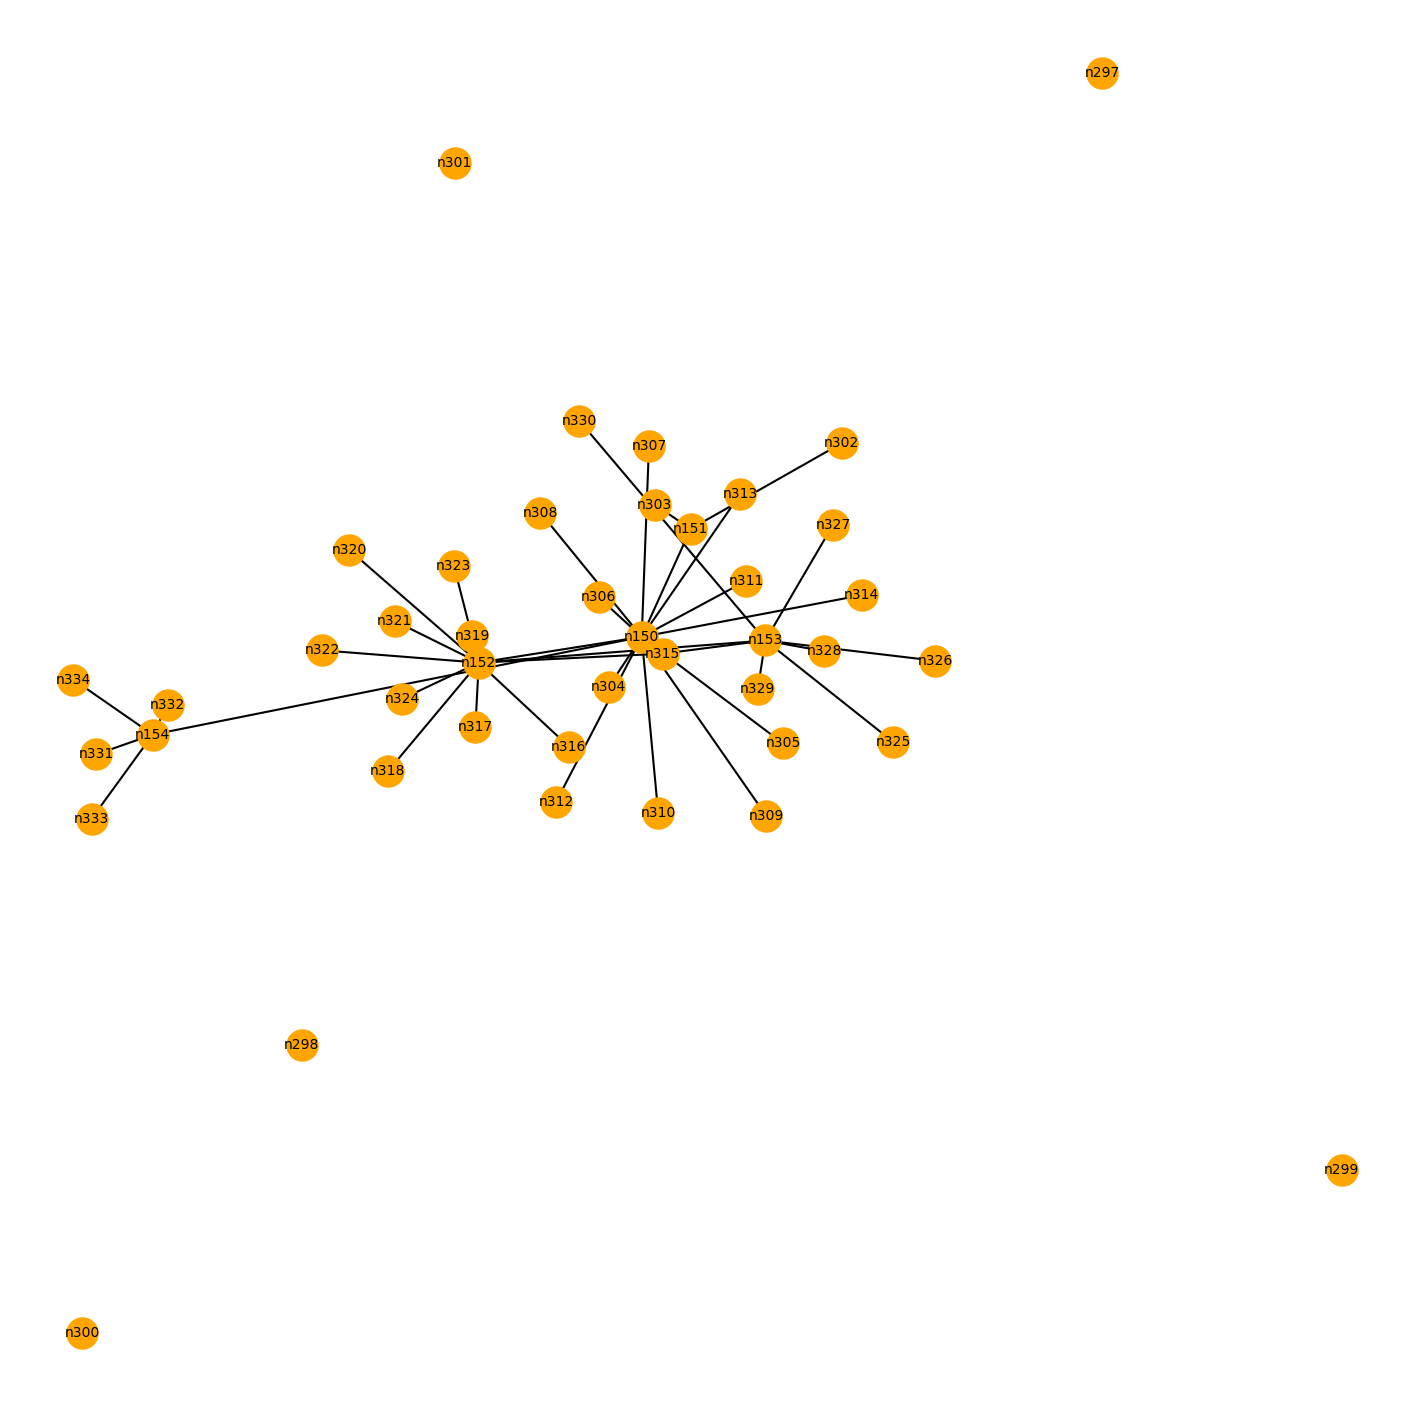

convergence signal!!! 476


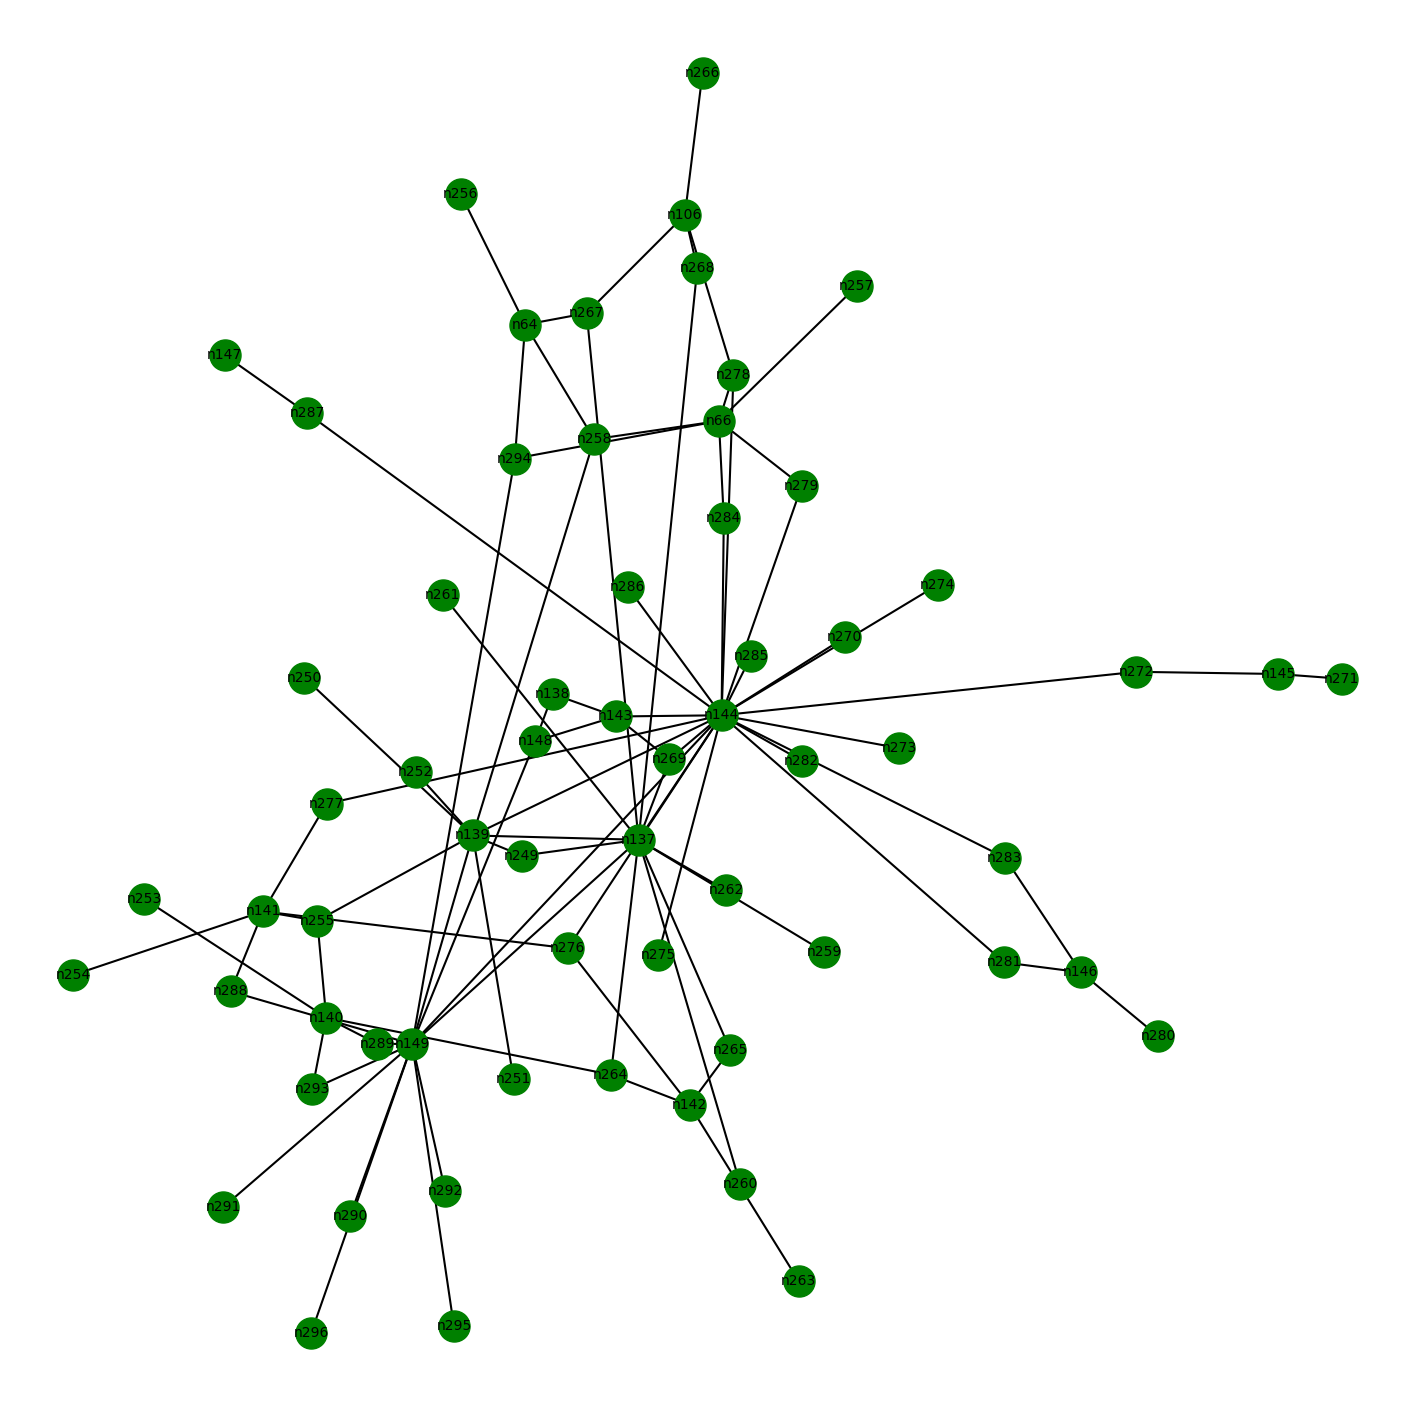

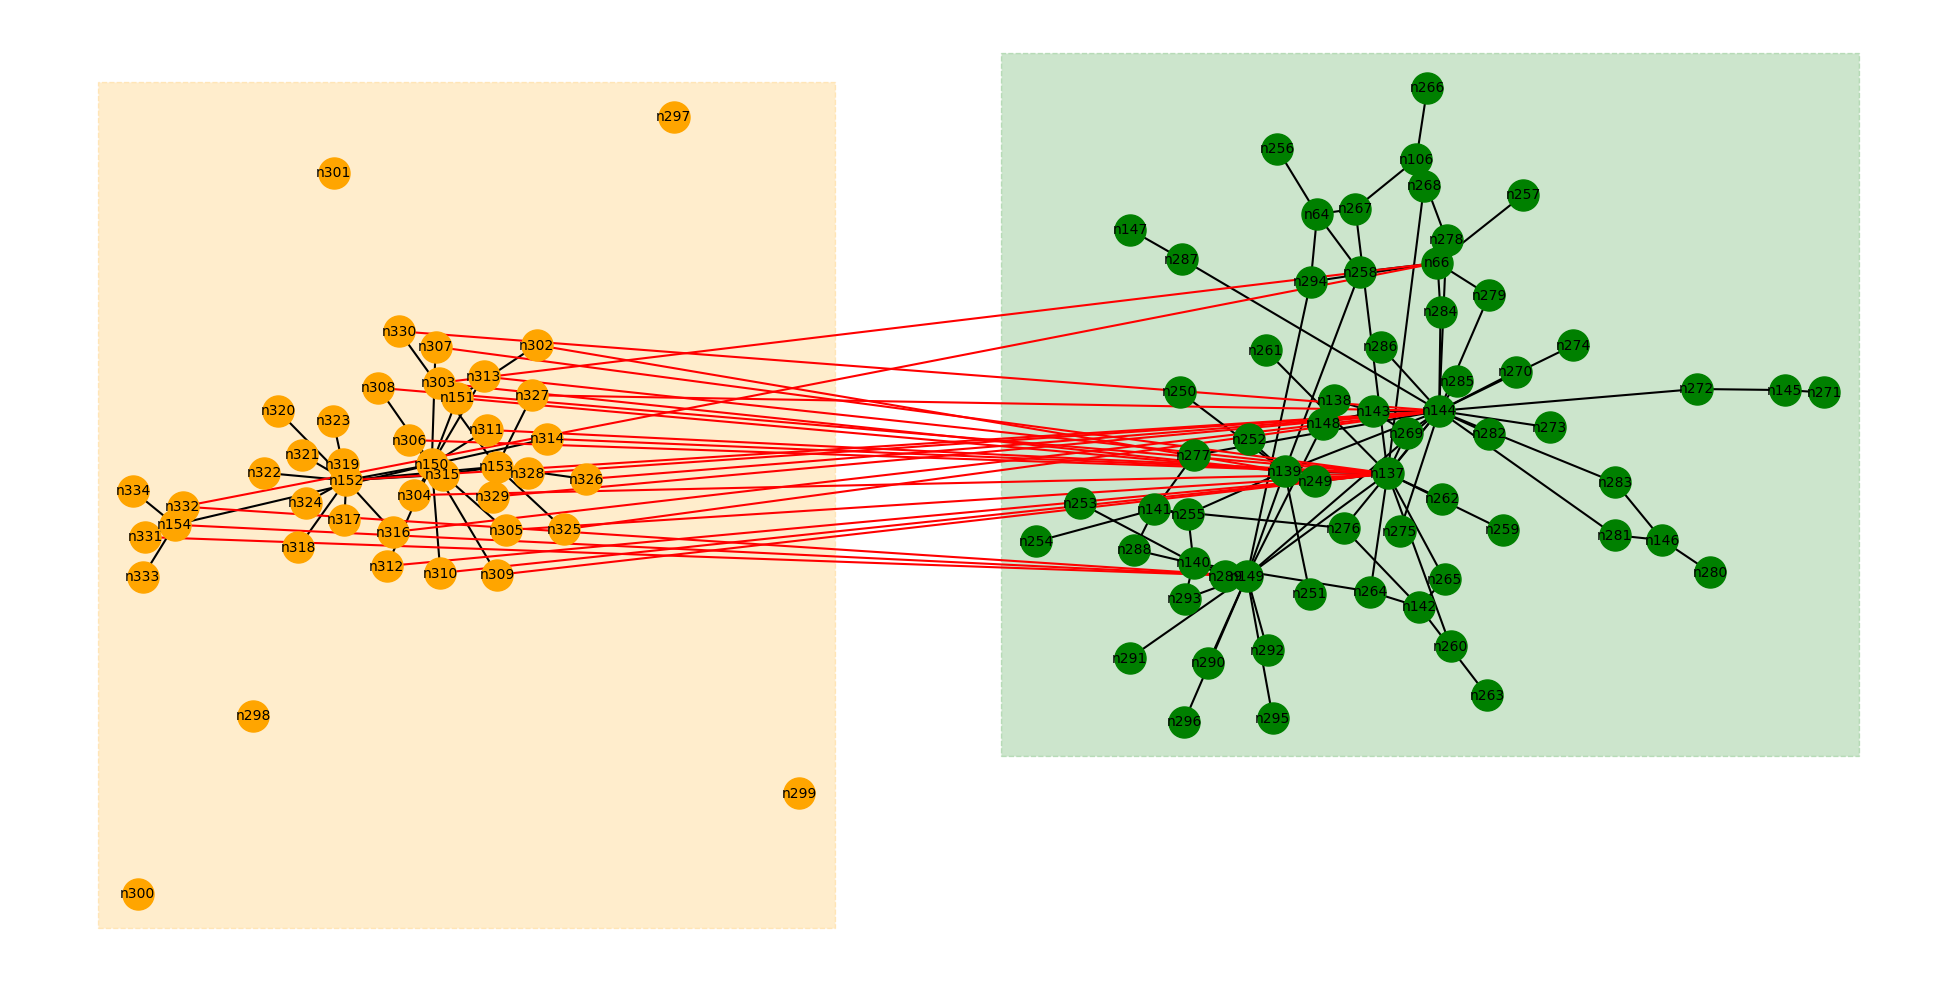

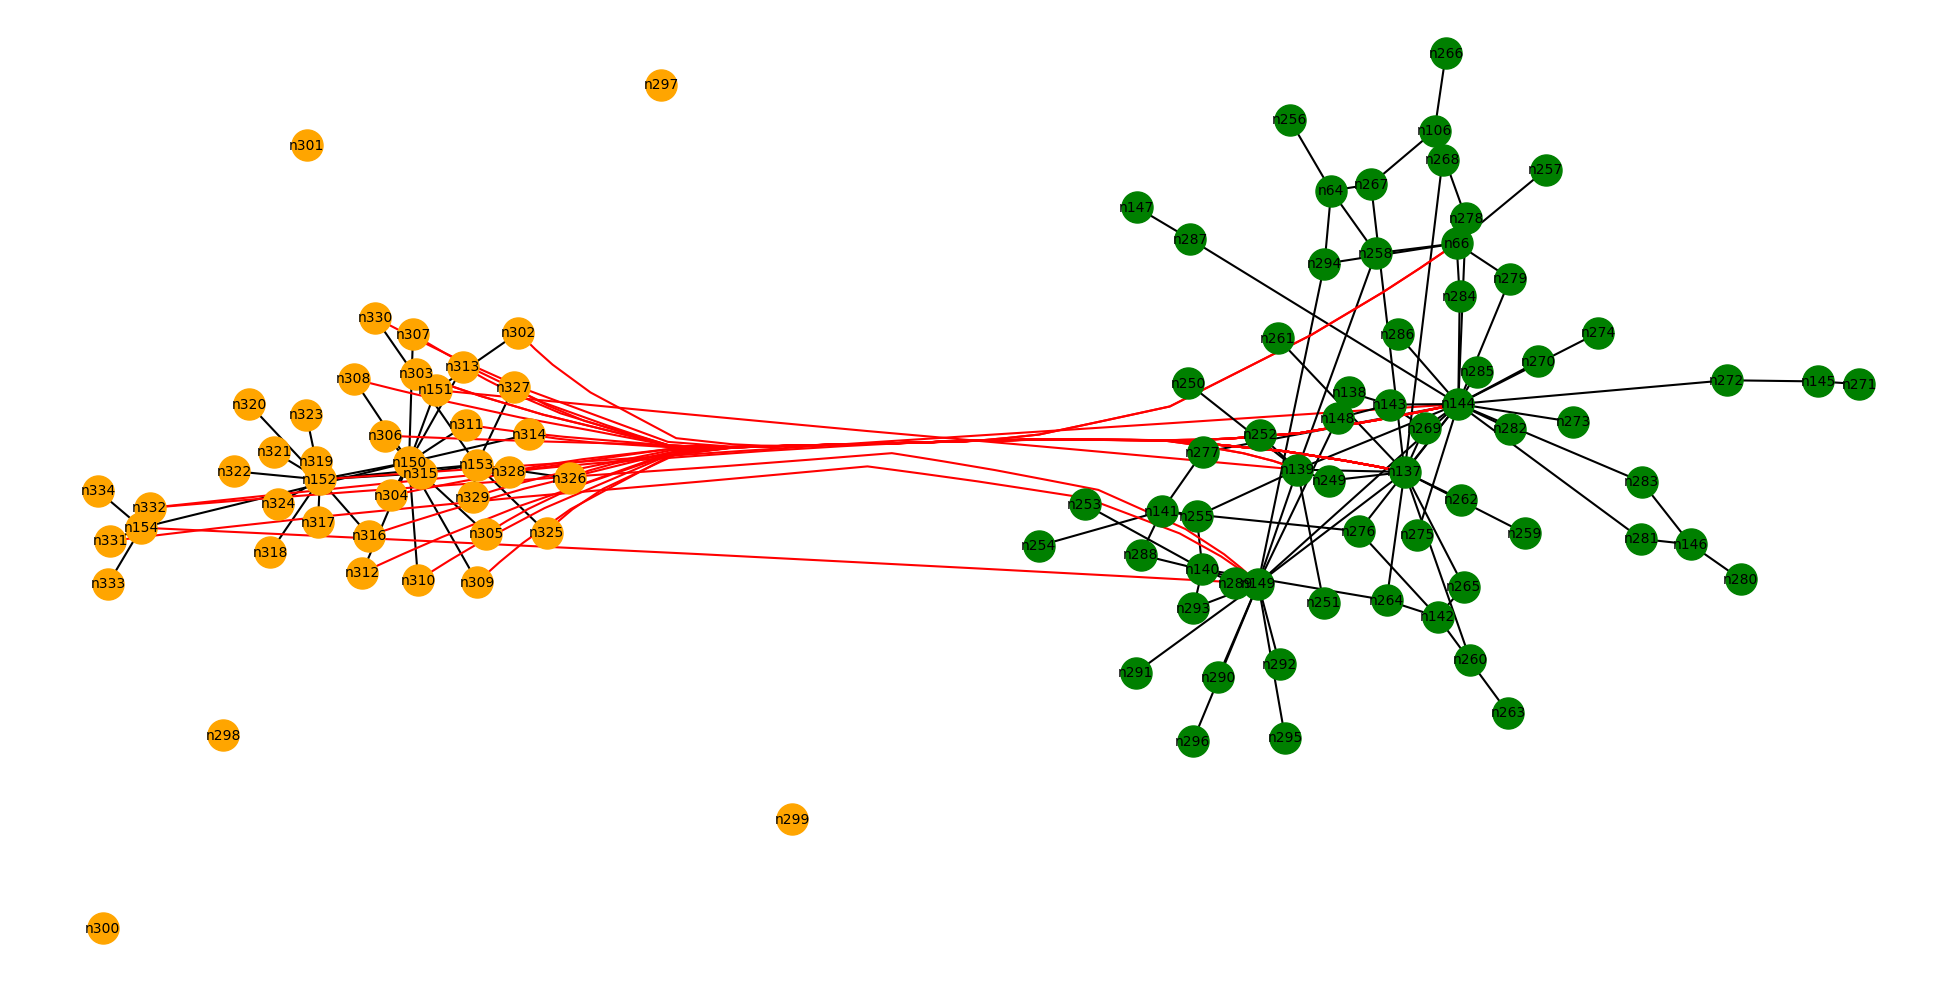

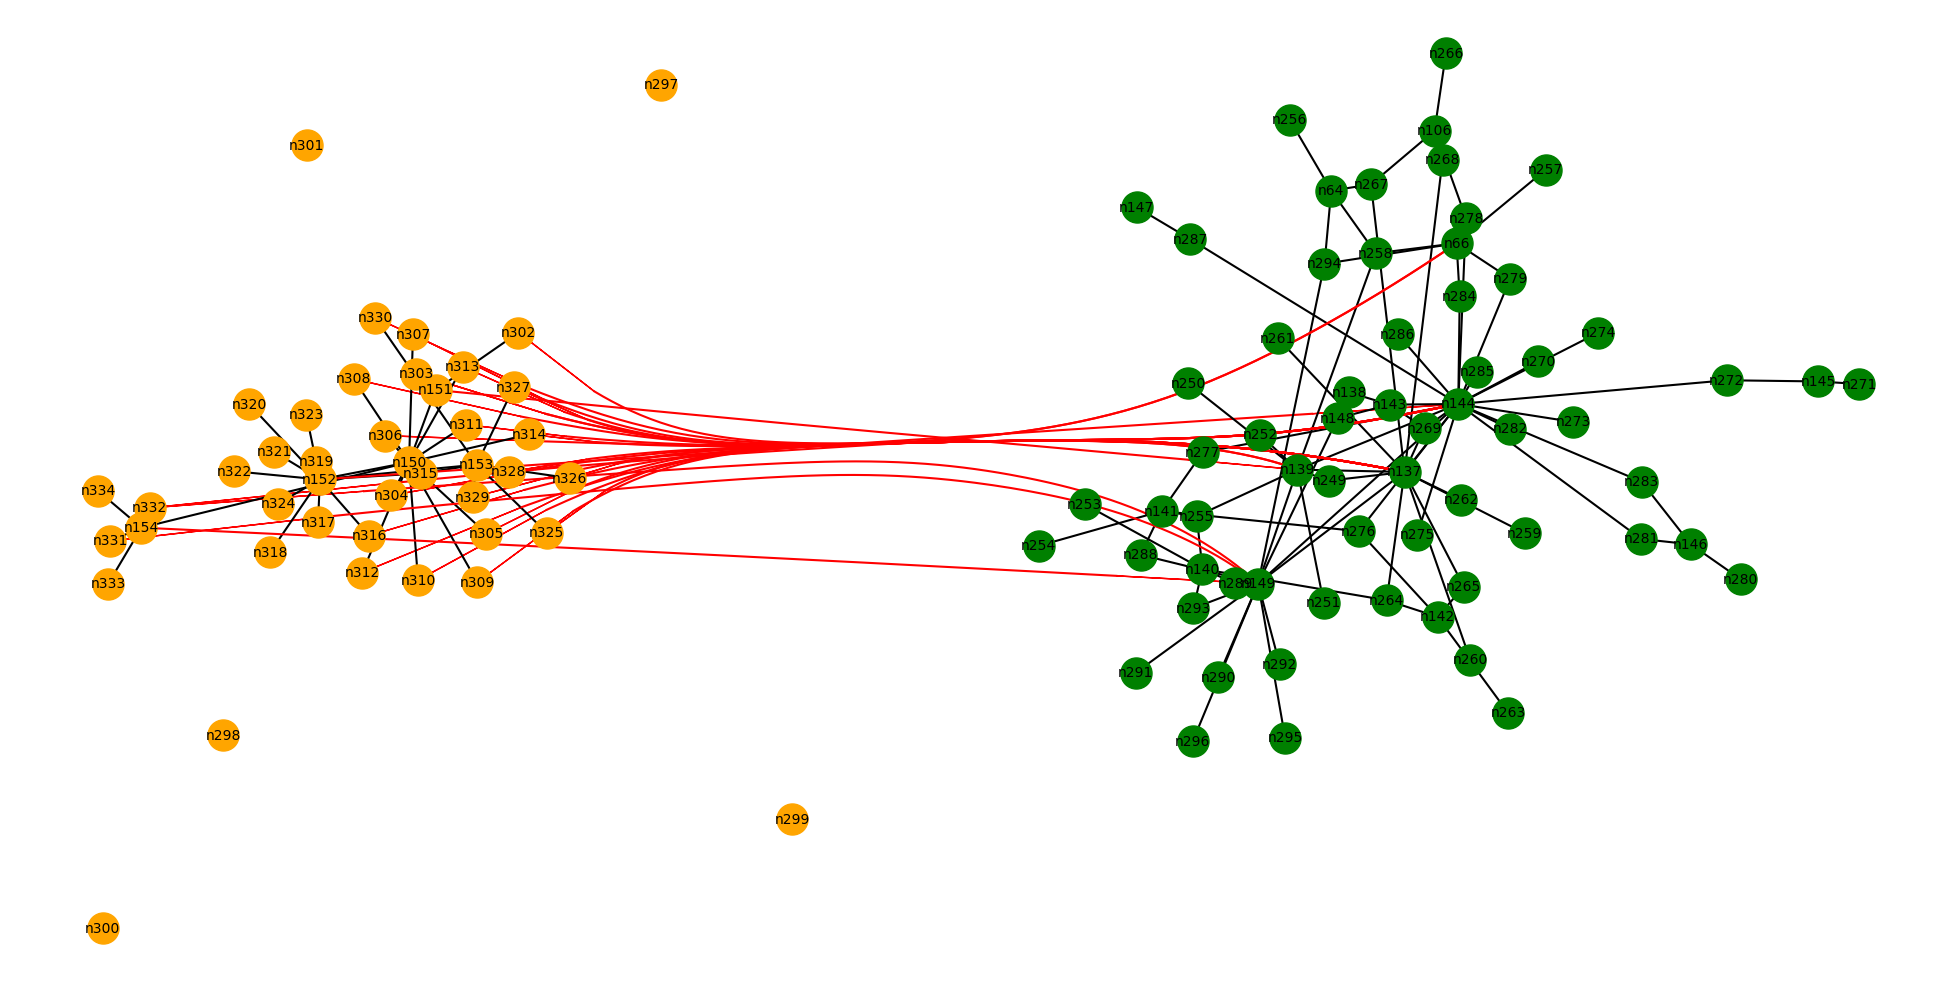

{'GapDevonshi': {'n150': (31.069751344007003, 24.256388874644262),
  'n151': (32.53312530299318, 28.112068004361348),
  'n152': (26.195557844501486, 23.337532117871532),
  'n153': (34.770162595287744, 24.128239349077987),
  'n154': (16.441720653723223, 20.76748671138291),
  'n297': (44.84727781940919, 44.38881406740012),
  'n298': (20.899757212361074, 9.700497215546239),
  'n299': (52.00592571710439, 5.223735656726382),
  'n300': (14.325794911734267, -0.5954270968514979),
  'n301': (25.47521478247395, 41.16105552624222),
  'n302': (37.052962658222775, 31.173853850512646),
  'n303': (31.46122762736398, 28.979819741093756),
  'n304': (30.083830270126683, 22.483343555365046),
  'n305': (35.29572514627586, 20.45468384890097),
  'n306': (29.778316994701076, 25.673503510233473),
  'n307': (31.286633549603632, 31.07229151686144),
  'n308': (28.03685117136829, 28.69546561707792),
  'n309': (34.80058795978914, 17.861998162119466),
  'n310': (31.56294492456244, 17.97029799392509),
  'n311': (34.

In [40]:
# nodes = combine_subgraphs("Datasets/argnet.dot",subgraphs=['GapDevonshi','YoungestStrata'],cs = [3,8],crep =[10,60],ll=[1,1],original=True, bundling = False, bounding = True)
# combine_subgraphs("Datasets/argnet.dot",subgraphs=['GapDevonshi','YoungestStrata'],nodes_positions = nodes ,cs = [3,8],crep =[10,60],ll=[1,1],original=False, bundling = True, bounding = False,bezier = False)
# combine_subgraphs("Datasets/argnet.dot",subgraphs=['GapDevonshi','YoungestStrata'],nodes_positions = nodes ,cs = [3,8],crep =[10,60],ll=[1,1],original=False, bundling = True, bounding = False)

### Political blogosphere network

We have two subgraphs: left or liberal, and right or conservative

In [41]:
nodes = combine_subgraphs("Datasets/polblogs.dot",cs = [3,8],crep =[10,60],ll=[1,1],original=True, bundling = False, bounding = True)
# combine_subgraphs("Datasets/argnet.dot",nodes_positions = nodes ,cs = [3,8],crep =[10,60],ll=[1,1],original=False, bundling = True, bounding = False,bezier = False)
# combine_subgraphs("Datasets/argnet.dot",nodes_positions = nodes ,cs = [3,8],crep =[10,60],ll=[1,1],original=False, bundling = True, bounding = False)